# GoogLeNet
- Inception 모듈 사용

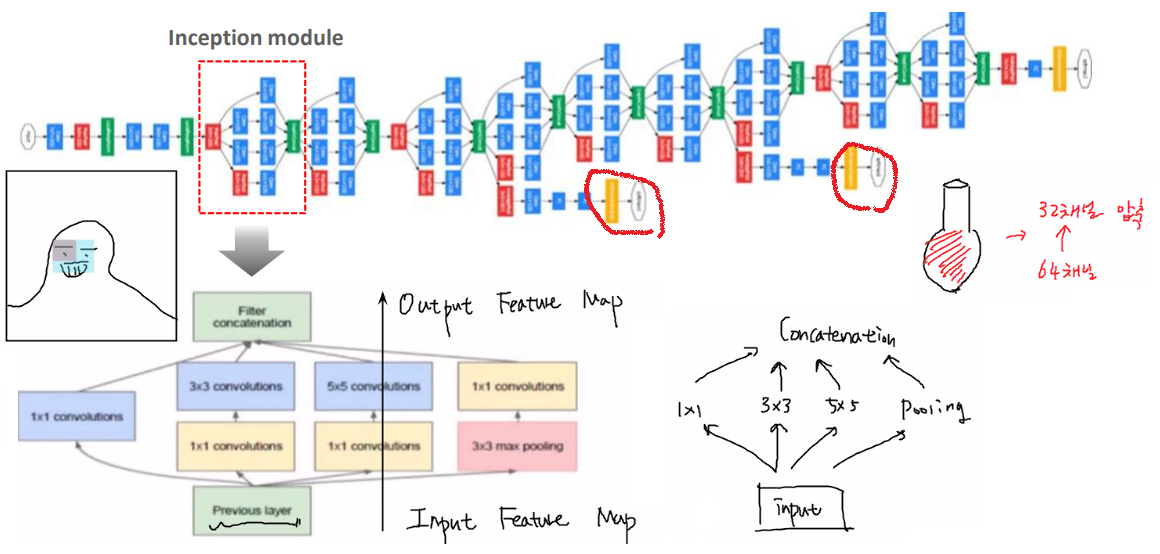

- 왼쪽 아래의 $H_{out},\;W_{out}$은 언제나 동일함

- 층이 깊다
  - 역전파 수행시 Gradient 소실 발생
    - 미분 값에 대한 부스팅 구간으로 보완
    - 중간 중간 있는 맨 아래(그림을 돌리면 왼쪽 곁가지, 붉은 색 실선의 테두리 부분)가 각각의 FCL임

# Inception Module

- 다양한 사이즈의 필터를 이용해서 하나의 이미지를 보는 것
  - Bottle Neck 구조라고도 할 수 있는 `1x1` Conv 연산을 통해 채널의 개수를 적절하게 조절하여 파라미터 개수를 줄일 수 있다.
  - 위 그림에서 노란색 1x1 Conv 3개
  - 이미지로부터 다양한 사이즈의 정보를 획득하고 **이어 붙인다**

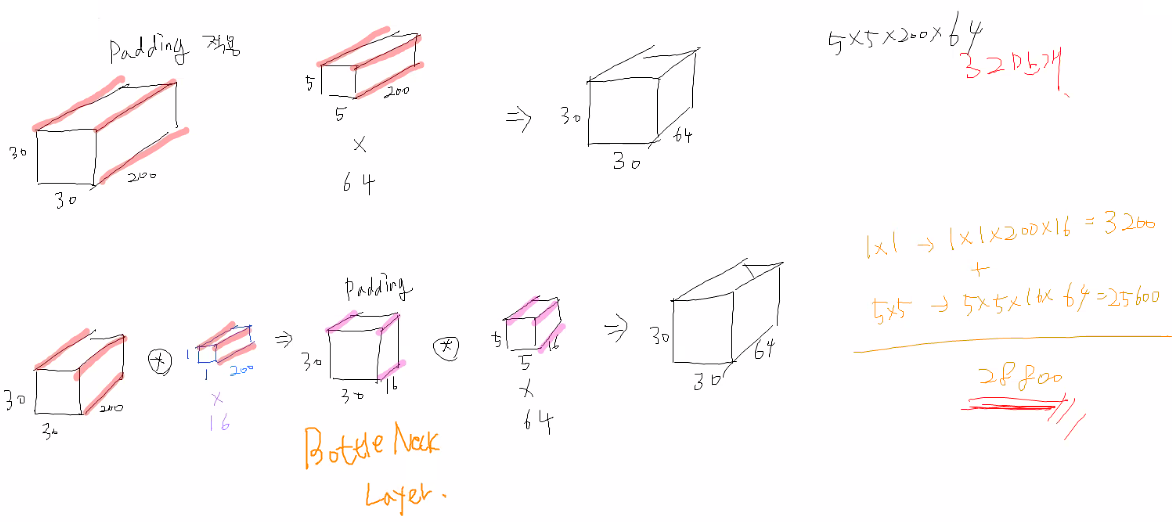

Bottle Neck이 무슨 일을 하는지 이해하는 과정이 필요

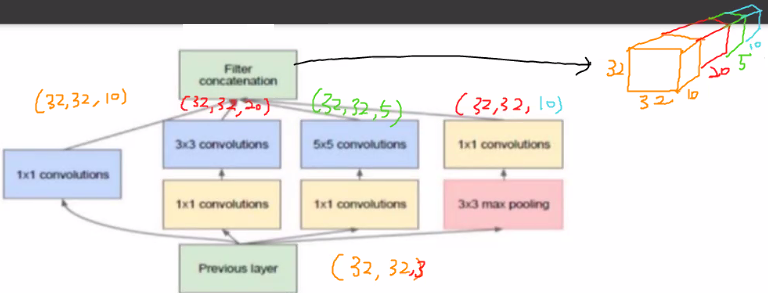

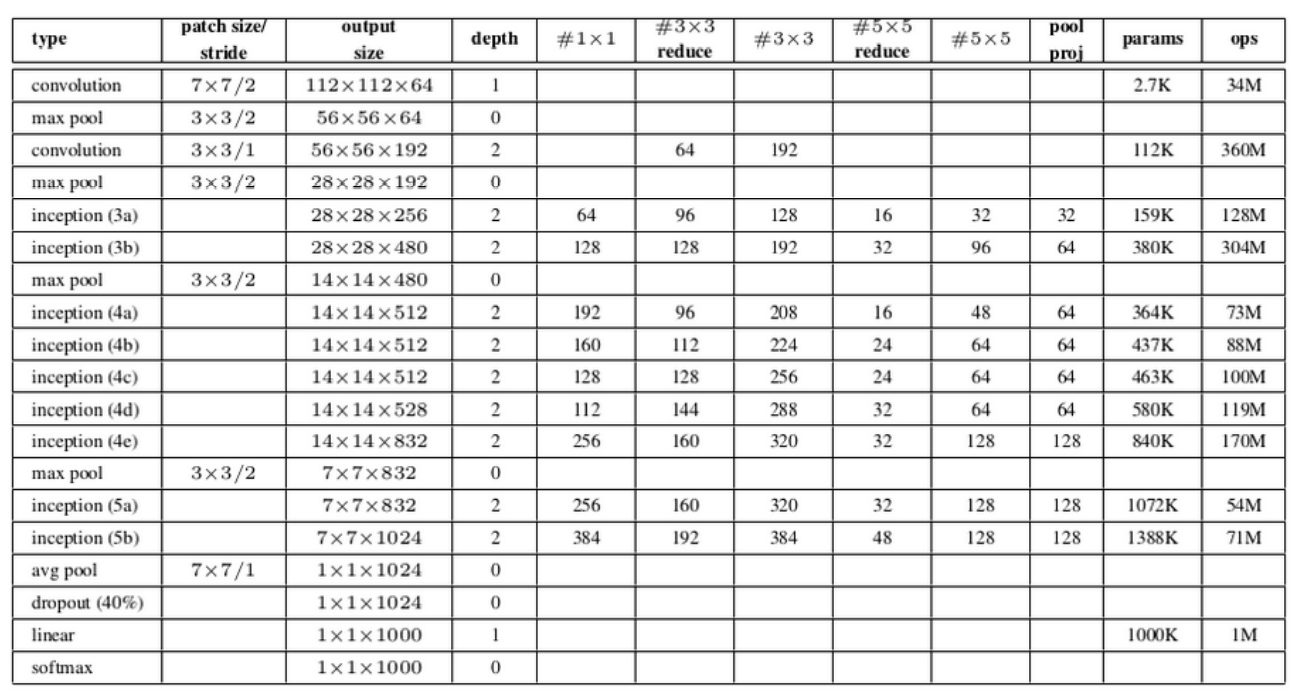

- Inception은 총 몇 번 있었나?
  - 9번
  - 한 블록 안에서는 (H x W)는 변하지 않고 'Channel'만 변한다.

- `reduce` : Bottle Neck
- `# n x n` : 흔한 Conv

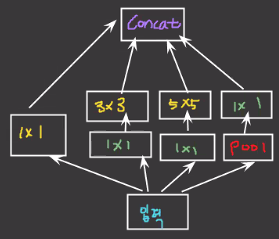

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate

# Inception Module
def inception_module(
    previous_x, # 이전 층에서 흘러 들어온 입력 feature map

    filters_1x1, # 1x1 Conv Cout

    filters_3x3_reduce, # 3x3 Conv의 BottleNeck Cout
    filters_3x3, # 3x3 Conv Cout

    filters_5x5_reduce, # 5x5 Conv의 BottleNec Cout
    filters_5x5, # 5x5 Conv Cout

    filters_pool_proj, #MaxPooling의 Projection(BottleNeck)
    name # 레이어의 이름
):
  # 1x1 Conv
  conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=1, activation='relu')(previous_x)

  # 1x1 BottleNeck -> 3x3 Conv
  conv_3x3_reduce = Conv2D(filters=filters_3x3_reduce, kernel_size=1, padding='same', activation='relu')(previous_x)
  conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=3, padding='same', activation='relu')(conv_3x3_reduce)

  # 1x1 BottleNeck -> 5x5 Conv
  conv_5x5_reduce = Conv2D(filters=filters_5x5_reduce, kernel_size=1, padding='same', activation='relu')(previous_x)
  conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=5, padding='same', activation='relu')(conv_5x5_reduce)

  # MaxPooling -> 1x1 BottleNeck(Projection)
    # 풀링을 하더라도 Output Feature Map의 크기가 변경되지 않아야 함 -> strides = 1, padding = 'same'
    # Concatenate()를 이용해 모든 결과를 이어붙이려면 (H, W)가 똑같아야 함
  pool_3x3 = MaxPooling2D(pool_size=3, strides=1, padding='same')(previous_x)
  pool_proj = Conv2D(filters=filters_pool_proj, kernel_size=1, padding='same', activation='relu')(pool_3x3)

  # 1 ~ 4 Feature Map 들을 Channel 축(Channel axis)으로 이어줘야 함
  output_filter_concat = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
  return output_filter_concat

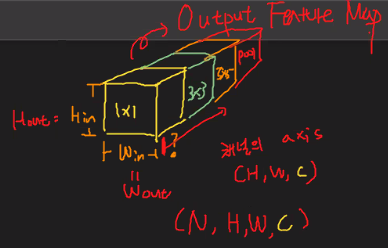

- axis = **-1**
  - 몇 개가 되는 마지막은 -1이다.

1. 크기가 다른 필터들을 여러 개 쓰는 이유
  - 한 이미지에 대해 각자 다른 시각으로 Input Feature Map을 본다고 생각하면 편함

2. BottleNeck의 존재 이유
  - Channel 수 조절
  - Filter에 들어가는 파라미터의 획기적 조절 가능
    - 결과물에는 큰 차이가 없음

# Inception Module 구조 확인

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Input
input = Input(shape=(224, 224, 3))

# Inception Module 사용 전 처리
x = Conv2D(filters=64, kernel_size=7, strides=2, activation='relu', padding='same', name='conv_1_7x7/2')(input)
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='max_pool_1_3x3/2')(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same', name='conv_2a_3x3/1')(x)  # depth = 1 // filters는 위(64) 혹은 아래(192)와 같이 가능
x = Conv2D(filters=192, kernel_size=3, strides=1, activation='relu', padding='same', name='conv_2b_3x3/1')(x) # depth = 2
x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='max_pool_2_3x3/2')(x)

# Inception Module
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')

x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')

x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='max_pool_3_3x3/2')(x)

x = inception_module(x, filters_1x1=192, filters_3x3_reduce= 96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5= 48, filters_pool_proj= 64, name='inception_4a')
x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5= 64, filters_pool_proj= 64, name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5= 64, filters_pool_proj= 64, name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5= 64, filters_pool_proj= 64, name='inception_4d')
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')

x = MaxPooling2D(pool_size=3, strides=2, padding='same', name='max_pool_4_3x3/2')(x)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')

# Fully Connected Layer
x = GlobalAveragePooling2D(name="avg_pool_5_3x3/1")(x)
x = Dropout(0.4)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                          

- GoogLeNet도 VGG에 비해 좋은 성능을 발휘 했으나, 더 깊이 층을 쌓아도 효과가 크지 않다는 것이 증명 되었다.

- **더 깊은 층을 쌓기 위해 Residual Network(잔차 네트워크) 등장**

# 깊은 Network의 주요 이슈
- 레이어의 깊이가 깊다
  - 모델이 이미지 데이터를 과하게 분석 할 수도 있다.
  - 과대 적합이 야기 된다.
- VGG 이후에 더 깊은 Network를 쌓아서 연구를 했는데, 네트워크의 깊이가 깊어질 수록 오히려 성능이 저하된다.
  - 커널 크기 조절, dropout, Weight Decay등으로 과대적합을 조절
  - 이 방법도 한계에 봉착했다.
- **Vanishing Gradient** 문제
  - 마지막 출력층에서 발생한 오차가 수많은 레이어에 역전파 되면서 앞 쪽으로 미분값이 전달될 수록 loss 값이 소실되는 현상이 발생
  - 제대로 **'최적의 LOSS 감소'**가 되지 않음.
